# k-Nearest-Neighbour classifiers
Here we use the k-nearest-neighbor method on the converted data from the descriptive_analysis.ipynb.
As reference we use dataMining_R_8_ml.Rmd (./uebung/knn_uebung/) from the lecture.

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor  
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [121]:
test = pd.read_csv('./data/converted_test_2020_07_09_00-15-27.csv', index_col=0, parse_dates=['Flight_Date','Request_Date'])
train = pd.read_csv('./data/converted_train_2020_07_09_00-15-27.csv', index_col=0, parse_dates=['Flight_Date','Request_Date'])

In [122]:
# Check for nulls
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


In [123]:
# storing number of rows as an a variable for later use
len_train=train.shape[0]

In [124]:
#coalescing the two columns for data treatment
train=train.append(test, sort=False)
train=train.reset_index()
train=train.drop('index',axis=1)
train.shape

(89207, 17)

In [125]:
# Scale numeric columns
# scaler = preprocessing.MinMaxScaler()

# Compute logarithmic values
trainFeatures = [['min_future_price_in_eur', 'Duration_Time', 'price_in_eur']]
for feature in trainFeatures:
    train[feature] = np.log1p(train[feature])
train

,Request_Date,Flight_Date,Duration_Time,Departure_hour,flight_unique_id,route_abb,flight_number,Price,Currency,min_future_price,price_in_eur,min_future_price_in_eur,Request_Weekday,Request_timeofday,Departure_timeofday,flight_distance_km,Request_hour
0,2019-06-03,2019-06-05,4.043051,19:00,2019-06-05 FR 146,SXF-STN,FR 146,208.07,€,259.07,5.342669,5.560951,Monday,Morning,Evening,907.2,11:00
1,2019-06-03,2019-06-05,3.806662,19:00,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,5.560951,5.560951,Monday,Night,Evening,907.2,23:00
2,2019-06-04,2019-06-05,3.496508,19:00,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,5.560951,5.560951,Tuesday,Morning,Evening,907.2,11:00
3,2019-06-04,2019-06-05,3.044522,19:00,2019-06-05 FR 146,SXF-STN,FR 146,259.07,€,259.07,5.560951,5.560951,Tuesday,Night,Evening,907.2,23:00
4,2019-06-03,2019-06-05,4.077537,21:00,2019-06-05 FR 147,STN-SXF,FR 147,127.49,£,223.37,4.736015,5.293034,Monday,Morning,Night,907.2,11:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89202,2019-07-30,2019-08-02,4.276666,22:00,2019-08-02 FR 8545,SXF-STN,FR 8545,42.83,€,NaN,3.780319,NaN,Tuesday,Night,Night,907.2,23:00
89203,2019-07-31,2019-08-02,4.094345,22:00,2019-08-02 FR 8545,SXF-STN,FR 8545,50.99,€,NaN,3.951051,NaN,Wednesday,Morning,Night,907.2,11:00
89204,2019-07-31,2019-08-02,3.871201,22:00,2019-08-02 FR 8545,SXF-STN,FR 8545,50.99,€,NaN,3.951051,NaN,Wednesday,Night,Night,907.2,23:00
89205,2019-08-01,2019-08-02,3.583519,22:00,2019-08-02 FR 8545,SXF-STN,FR 8545,50.99,€,NaN,3.951051,NaN,Thursday,Morning,Night,907.2,11:00


In [126]:
# Hot encoding for categorical values
train = pd.get_dummies(train, columns=['Request_Date', 'Flight_Date', 'flight_number', 'Request_Weekday', 'Request_timeofday', 'Departure_timeofday', 'Departure_hour', 'Request_hour'], drop_first=True)

In [127]:
# Drop columns we do not need from train
train_dropped = train.drop(columns=['route_abb', 'Currency', 'flight_unique_id', 'Price', 'flight_distance_km'])

In [128]:
# Splitting test and train data
train_df=train_dropped[:len_train]
test_df=train_dropped[len_train:]

In [129]:
# Generate test and target / Figure out which features to drop. 'min_future_price_in_eur' needs to be dropped!
x = train_df.drop(columns=['min_future_price_in_eur'])
y = train_df['min_future_price_in_eur'].values

# Build model

In [130]:
# Writing a function to evaluate model performance using KFOLD and cross validation
def rmsle_cv(model):
    kfold=KFold(n_splits=2, shuffle=True, random_state=10).get_n_splits(x)
    rmse=np.sqrt(-cross_val_score(model,x,y,cv=kfold, scoring='neg_mean_squared_error'))
    return rmse

In [131]:
lightgbm=LGBMRegressor(objective= 'regression',
         boosting= 'gbdt',
         num_iterations= 3000,   
         learning_rate= 0.06,  
         num_leaves= 40,  
         max_depth= 24,   
         min_data_in_leaf=11,  
         max_bin= 4, 
         metric= 'l2_root')

In [132]:
xgb=XGBRegressor(max_depth=9, 
                   learning_rate=0.5, 
                   n_estimators=112, 
                   objective='reg:squarederror', 
                   booster='gbtree', 
                   n_jobs=1, 
                   nthread=None, 
                   gamma=0, 
                   min_child_weight=1, 
                   max_delta_step=0, 
                   subsample=1, 
                   colsample_bytree=1, 
                   colsample_bylevel=1, 
                   reg_alpha=0.89, 
                   reg_lambda=1, 
                   scale_pos_weight=1, 
                   base_score=0.5, 
                   random_state=0, 
                   seed=None)

In [133]:
grb=GradientBoostingRegressor(learning_rate=0.1,n_estimators=400, max_depth=12
                              ,subsample=0.8,
                              verbose=False,random_state=10)

In [134]:
svr = Pipeline([('Scaler',RobustScaler()), ('SVR',SVR(C= 10000, epsilon= 0.008, gamma=0.009))])

In [135]:
krr=KernelRidge(alpha=1, kernel='polynomial', gamma=0.001,degree=3,coef0=5)

In [136]:
rf=RandomForestRegressor(n_estimators=3000, oob_score = False, n_jobs = -1,random_state =50, max_features = "auto", min_samples_leaf = 2,warm_start=True,criterion='mse',max_depth=50)

In [137]:
# Final ensemble that uses outputs from each model regressor and the original data in the meta regressor XGB
avg=StackingCVRegressor(regressors=(lightgbm,
                                    grb
                                    #svr,
                                    #krr,
                                    #rf
                                   ),meta_regressor=xgb, use_features_in_secondary=True)

In [138]:
# Function to calculate RMSE error of the complete model for reference, similiar to rmsle_cv without KFOLD CV
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [139]:
X=np.array(x)
Y=np.array(y)
# Fitting the model on the train data and predicting the min future price values
lightgbm.fit(X,Y)
y_pred=lightgbm.predict(X)

/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


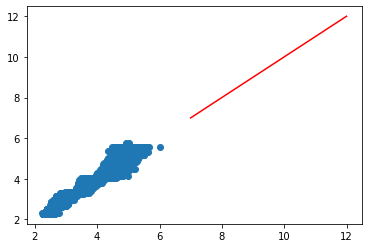

In [140]:
# Plot of the model prediction with the original price values in the training data set to undestand model fit
plt.scatter(list(y_pred),y)
plt.plot(range(7,13),range(7,13),'r')

In [141]:
# RMSE value of the model on training data
rmsle(y,y_pred)

0.10697572900396474

In [142]:
# Predictions of test data
Predict=lightgbm.predict(np.array(test_df.drop('min_future_price_in_eur',axis=1)))
# Converting min future price back to original scale and making it integer
Predict=np.exp(Predict)
Predict=Predict.astype(float)
# Converting predicted values to dataframe
Submission=pd.DataFrame(Predict,columns=['min_future_price_in_eur'])
# Final Submission
Submission.to_excel('Submission_rf.xlsx')